In [103]:
import transformers

SEED = 69420
DO_TRAINING = True
EPOCHS_TO_TRAIN = 100
BASE_MODEL = "microsoft/resnet-50"
OUTPUT_MODEL_DIR = "./models/resnet-pcb-ext/"
IMAGE_PROCESSOR_CLASS = transformers.AutoImageProcessor
IMAGE_CLASSIFICATION_CLASS = transformers.ResNetForImageClassification


In [104]:
from datasets import load_dataset
from datasets import DatasetDict

ds = load_dataset("./datasets/training/")
testing_set = load_dataset("./datasets/testing/")

ds_train_devtest = ds['train'].train_test_split(test_size=0.2, seed=SEED)

dataset = DatasetDict({
    'train': ds_train_devtest['train'],
    'eval': ds_train_devtest['test'],
    # 'test': ds_devtest['test']
    'test': testing_set["train"]
})

dataset


Resolving data files: 100%|██████████| 88/88 [00:00<00:00, 433723.56it/s]


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 969
    })
    eval: Dataset({
        features: ['image', 'label'],
        num_rows: 243
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 88
    })
})

In [105]:
try:
    model_name = BASE_MODEL if DO_TRAINING else OUTPUT_MODEL_DIR
except OSError:
    model_name = BASE_MODEL

processor = IMAGE_PROCESSOR_CLASS.from_pretrained(model_name)
# processor(dataset["train"][-1]["image"], return_tensors="pt")


In [106]:
def transform(batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = processor([x for x in batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['label'] = batch['label']
    return inputs

prepared_ds = dataset.with_transform(transform)
# prepared_ds["eval"][0]


In [107]:
import torch


def collate_fn(batch):
    return {
        "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
        "labels": torch.tensor([x["label"] for x in batch]),
    }


In [108]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


In [109]:
labels = dataset['train'].features['label'].names

model = IMAGE_CLASSIFICATION_CLASS.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True
)


In [110]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir=OUTPUT_MODEL_DIR,
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=EPOCHS_TO_TRAIN,
  # fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)


In [111]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["eval"],
    tokenizer=processor,
)


In [112]:
if DO_TRAINING:
    try:
        train_results = trainer.train(resume_from_checkpoint=True)
    except ValueError:
        train_results = trainer.train()
    trainer.save_model()
    trainer.log_metrics("train", train_results.metrics)
    trainer.save_metrics("train", train_results.metrics)
    trainer.save_state()


In [113]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)


100%|██████████| 11/11 [00:01<00:00,  6.44it/s]

***** eval metrics *****
  eval_accuracy           =        1.0
  eval_loss               =        0.0
  eval_runtime            = 0:00:01.98
  eval_samples_per_second =     44.344
  eval_steps_per_second   =      5.543


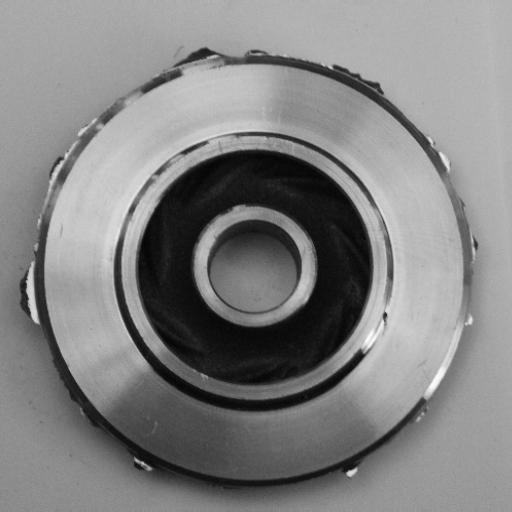

'actual: defective'

'predicted: defective'

In [114]:
processor = IMAGE_PROCESSOR_CLASS.from_pretrained(OUTPUT_MODEL_DIR)

model = IMAGE_CLASSIFICATION_CLASS.from_pretrained(
    OUTPUT_MODEL_DIR,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True
)

idx = 15
image = dataset["test"][idx]["image"]
actual_label = dataset["test"][idx]["label"]
inputs = processor(image, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

predicted_label = logits.argmax(-1).item()
labels[predicted_label]

display(image, f"actual: {labels[actual_label]}", f"predicted: {labels[predicted_label]}")
